# Описание задачи

## Содержимое исходных датасетов

* `GOLD_RECOVERY_FULL_NEW` - исходные данные
* `GOLD_RECOVERY_TEST_NEW` - тестовая выборка
* `GOLD_RECOVERY_TRAIN_NEW` - обучающая выборка

## Описание данных

### Технологический процесс

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate ** — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

### Параметры этапов

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

## Наименования признаков

Шаблон наименования признака - `[этап].[тип_параметра].[название_параметра]`

Возможные значения для блока `[этап]`:

* `rougher` — флотация
* `primary_cleaner` — первичная очистка
* `secondary_cleaner` — вторичная очистка
* `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

* `input` — параметры сырья
* `output` — параметры продукта
* `state` — параметры, характеризующие текущее состояние этапа
* `calculation` — расчётные характеристики


## Задача моделирования

На базе предоставленных данных о качестве сырья на этапах обработки руды необходимо обучить модель для прогнозирования целевых величин.

Нужно спрогнозировать сразу две величины:

* эффективность обогащения чернового концентрата - `rougher.output.recovery`

* эффективность обогащения финального концентрата - `final.output.recovery`

In [1]:
# сохраним значения целевых признаков в неизменяемую последовательность данных

TARGET_FEATURES = ("rougher.output.recovery", "final.output.recovery")

# Подготовка и анализ данных

## Предобработка данных

In [2]:
# импортируем нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [3]:
FULL = pd.read_csv(
    "/datasets/gold_recovery_full_new.csv"
)

TRAIN = pd.read_csv(
    "/datasets/gold_recovery_train_new.csv"
)

TEST = pd.read_csv(
    "/datasets/gold_recovery_test_new.csv"
)

In [4]:
for df in [FULL, TRAIN, TEST]:
    print(df.shape)

(19439, 87)
(14149, 87)
(5290, 53)


In [5]:
FULL.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [6]:
TRAIN.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [7]:
TEST.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [8]:
# исходя из предположения о том, что тестовая и обучающая выборки эквивалентны содержимому полного датасета, проверим FULL на наличие полных дубликатов

print("Количество полных дубликатов:", (FULL.duplicated()).sum())

Количество полных дубликатов: 0


In [9]:
print("Проверим наличие целевых признаков в обучающей выборке:")
for x in TARGET_FEATURES:
    print(x in TRAIN.columns)
print()
print("Проверим наличие целевых признаков в тестовой выборке:")
for x in TARGET_FEATURES:
    print(x in TEST.columns)

Проверим наличие целевых признаков в обучающей выборке:
True
True

Проверим наличие целевых признаков в тестовой выборке:
False
False


In [10]:
# сформируем список наименований признаков, которыми мы не располагаем в тестовой выборке, а значит - не будем располагать и при использовании модели в проде

MISSING_FEATURES = []
USEFUL_FEATURES = []

for TRAIN_FEATURE in TRAIN.columns:
    if TRAIN_FEATURE not in TEST.columns:
        MISSING_FEATURES.append(TRAIN_FEATURE)
    else:
        USEFUL_FEATURES.append(TRAIN_FEATURE)

MISSING_FEATURES

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Так как на на данных обучающей выборке мы планируем обучить модель и использовать ее для предсказания значений целевых признаков, то и для обучения должны использоваться только признаки, доступные на соответствующем производственном этапе. Таким образом, мы оставим в обучающей выборке те же признаки, что есть в тестовой. 

In [11]:
# для последующей оценки эффективности сохраним целевые признаки

# для корректного выбора из множества признаков воспользуемся легендой списком признаков, которыми мы располагаем в обучающей выборке

for x in TRAIN.columns:
    if "rougher" in x:
        print(x)

rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.feed_au
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_d_air
rougher.state.floatbank10_d_level
rougher.state.floatbank10_e_air
rougher.sta

In [12]:
# для расчета эффективности сформируем датафрейм с признаками, необходимыми для расчета
# туда же добавим целевой признак, с которым будем проводить сравнение

EFFICIENCY_CALCULATION_DF = TRAIN[
    [
        "date",
        "rougher.output.concentrate_au",
        "rougher.input.feed_au",
        "rougher.output.tail_au",
        "rougher.output.recovery",
    ]
]

In [13]:
# При помощи логической индексации отбросим ненужные признаки и запишем данные в отдельный датафрейм

PREPROCESSED_TRAIN = TRAIN.loc[:, USEFUL_FEATURES]

In [14]:
PREPROCESSED_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   primary_cleaner.input.sulfate               14129 non-null  float64
 2   primary_cleaner.input.depressant            14117 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14049 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      14147 non-null  float64
 10  primary_cl

In [15]:
TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [16]:
print(
    "Количество записей в обучающей выборке без пропусков в каких-либо признаках:",
    len(PREPROCESSED_TRAIN[~PREPROCESSED_TRAIN.isnull().any(axis=1)]),
)

print(
    f"Датасет без пропусков составляет {len(PREPROCESSED_TRAIN[~PREPROCESSED_TRAIN.isnull().any(axis=1)])/len(PREPROCESSED_TRAIN):.2%} от исходного датасета"
)

Количество записей в обучающей выборке без пропусков в каких-либо признаках: 12679
Датасет без пропусков составляет 89.61% от исходного датасета


Мы видим, что полный отказ от строк с пропусками потребует удалить из выборки порядка 10%, что очень много. Необходим альтернативный вариант. 

Оптимальным вариантом представляется заполнение пропусков предыдущими не пустыми значениями - так мы обогатим датасет данными одновременно не добавляя в него не объективных (расчтеных) значений.

In [17]:
# заполним пропуски в данных, используя предыдущее не пустое значение

PREPROCESSED_TRAIN = PREPROCESSED_TRAIN.fillna(method="ffill")

In [18]:
PREPROCESSED_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   primary_cleaner.input.sulfate               14149 non-null  float64
 2   primary_cleaner.input.depressant            14149 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14149 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14149 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      14149 non-null  float64
 10  primary_cl

In [19]:
# оценим визуально числовые данные

PREPROCESSED_TRAIN.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,133.213938,8.855281,7.322310,0.881455,1608.010260,-488.776276,1608.624449,-489.172523,1608.881920,-489.606288,1542.262260,-483.463589,8.579195,3.505465,473.938265,60.239856,36.290933,7.866577,11.746225,5.853080,11.368269,5.803930,1124.717520,-369.470105,1320.724794,-464.261562,1299.381782,-465.057320,1210.335236,-465.457377,1084.329957,-464.919119,1035.490299,-464.688631,29.685606,-502.223723,24.900592,-503.695352,29.242738,-478.245518,22.656283,-488.924813,19.979788,-478.702912,15.486812,-460.237231,16.774657,-483.957839,13.064236,-483.967726,19.576675,-506.805007
std,39.604988,3.375435,0.614062,0.375683,128.381451,35.703034,131.101079,33.603376,134.260578,35.622851,278.383053,47.099473,1.896284,1.090064,104.137249,23.005310,4.977652,1.919506,3.307977,1.106509,3.798083,1.239005,169.308048,93.955779,183.164531,57.400744,213.411457,55.903513,210.431555,55.771393,186.264888,56.602962,175.052279,56.645965,5.812810,60.279579,6.016986,62.835150,5.636710,54.653487,4.995841,41.926730,5.663611,50.739376,5.255555,58.848850,5.831978,37.892065,5.765567,39.206771,5.764496,37.086065
min,0.003112,0.000000,1.080000,0.000005,0.006352,-798.641662,0.008700,-740.122129,0.015159,-799.803073,0.008655,-799.788598,0.010000,0.010000,0.012786,9.659576,0.010000,0.010000,0.001083,0.001428,0.000098,0.000290,-0.041078,-650.202881,-0.653384,-650.260008,-0.035112,-640.995627,-0.554299,-640.519003,-1.970275,-649.443911,-2.430587,-649.880981,0.0775

**Промежуточные выводы:**

1. Наблюдаем, что датафреймы имеют разный размер: около 25% от исходного объема (FULL) занимает тестовая выборка, что выглядит довольно логично в рамках поставленной задачи
2. Тестовая выборка не содержит 34 признака из полной и обучающей выборки - вероятно, это необходимо проверить для избежания утечки признаков при использовании модели
3. Полные дубликаты в исходном датафрейме отсутствуют
4. Целевые признаки имеются в обучающей выборке и отсутствуют в тестовой выборке, что соответствует нашим требованиям
5. Пропущенных значений в тестовой выборке значительно меньше, чем в обучающей
6. Визуальная оценка числовых значений признаков не позволяет говорить о наличии явных выбросов, но без желательно такую оценку провести с помощью профильного эксперта для которого числовые признака в данной выборке будут иметь осмысленное значение

**Корректирующие действия:**

1. Установлено, что в тестовой выборке отсутствуют значения, характеризующие финальные этапы каждого из звеньев технологической цепочки - содержание металлов в концентрате и отвальных хвостах. Эти значения из обучающей выборки отброшены в целях обучения модели.
2. Пропуски в обучающей выборке заменены предыдущими не пустыми значениями.

## Расчет эффективности

Для расчета эффективности обогащения и сверки ее с уже имещимся признаком `rougher.output.recovery` (выходной продукт этапа флотации) воспользуемся формулой, предоставленной заказчиком:

Recovery = (C * (F - T) / F * (C - T)) * 100, где 

C - доля золота в концентрате после флотации/очистки

F - доля золота в сырье/концентрате до флотации/очистки

T - доля золота в отвальных хвостах после флотации/очистки

Так как мы говорим о флотации, то нас интересуют признаки со словом `rougher`, описывающем этап технологического процесса. Для переменных, хранящих величины после завершения процесса, используется тип параметра `output` и, соответственно, `input` для тех, что содержат входные данные. 

In [20]:
# получаем расчетную эффективность при помощи отдельной функции


def recovery_calculator(df):
    C = df["rougher.output.concentrate_au"]
    F = df["rougher.input.feed_au"]
    T = df["rougher.output.tail_au"]
    CALCULATED_RECOVERY = ((C * (F - T)) / (F * (C - T))) * 100
    df = pd.concat([df, CALCULATED_RECOVERY], axis=1)
    df = df.rename(columns={0: "calculated_recovery"})
    return df

In [21]:
# применяем функцию

EFFICIENCY_CALCULATION_DF = recovery_calculator(EFFICIENCY_CALCULATION_DF)

In [22]:
# оцениваем полученный результат

EFFICIENCY_CALCULATION_DF

,date,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,calculated_recovery
0,2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763,87.107763
1,2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261,86.843261
2,2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308,86.842308
3,2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430,87.226430
4,2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794,86.688794
...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,18.603550,5.335862,0.748633,89.574376,89.574376
14145,2018-08-18 07:59:59,18.441436,4.838619,0.771582,87.724007,87.724007
14146,2018-08-18 08:59:59,15.111231,4.525061,0.685059,88.890579,88.890579
14147,2018-08-18 09:59:59,17.834772,4.362781,0.567130,89.858126,89.858126


Для расчета воспользуемся функцией для расчета соответствующей метрики из библиотеки sklearn:

In [23]:
print(
    "MAE для расчетных значений составляет:",
    mean_absolute_error(
        y_true=EFFICIENCY_CALCULATION_DF["rougher.output.recovery"],
        y_pred=EFFICIENCY_CALCULATION_DF["calculated_recovery"],
    ),
)

MAE для расчетных значений составляет: 9.73512347450521e-15


Наблюдаем ничтожно малое значение. Таким образом, можно говорить о корректном имеющемся значении эффективности обогащения руды. 

## Анализ данных

### Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

In [24]:
# сформируем перечень признаков в наименовании которых присутствует название металла

METALS = ("au", "ag", "pb")

METALS_FEATURES = []

for FEATURE in TRAIN.columns:
    for METAL in METALS:
        if METAL in FEATURE:
            METALS_FEATURES.append(FEATURE)

In [25]:
METALS_FEATURES

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail

In [26]:
# зачистим список от нерелеватных наименований признаков

for FEATURE in [
    "secondary_cleaner.output.tail_ag",
    "secondary_cleaner.output.tail_pb",
    "secondary_cleaner.output.tail_au",
    "rougher.calculation.floatbank10_sulfate_to_au_feed",
    "rougher.calculation.au_pb_ratio",
    "rougher.calculation.sulfate_to_au_concentrate",
    "rougher.calculation.floatbank11_sulfate_to_au_feed",
    "rougher.calculation.au_pb_ratio",
    "rougher.input.feed_ag",
    "rougher.input.feed_pb",
    "rougher.input.feed_au",
]:
    METALS_FEATURES.remove(FEATURE)

In [27]:
METALS_FEATURES

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au']

In [28]:
# соберем списки признаков для характеристик выходного концентрата и отвальных хвостов

CONCENTRATE_F = set()
TAIL_F = set()


for FEATURE in METALS_FEATURES:
    if "concentrate" in FEATURE:
        FEATURE = FEATURE[:-3] + "_"
        CONCENTRATE_F.add(FEATURE)
    else:
        FEATURE = FEATURE[:-3] + "_"
        TAIL_F.add(FEATURE)

CONCENTRATE_F = sorted(list(CONCENTRATE_F))
TAIL_F = sorted(list(TAIL_F))

In [29]:
CONCENTRATE_F

['final.output.concentrate_',
 'primary_cleaner.output.concentrate_',
 'rougher.output.concentrate_']

In [30]:
TAIL_F

['final.output.tail_', 'primary_cleaner.output.tail_', 'rougher.output.tail_']

Наблюдаем следующее: 

1. В числе отобранных признаков у нас есть данные как о концентрацим металла в исходном сырье, так и в выходном концентрате
2. С визуальной точки зрения наиболее репрезентативным будет построить распределения для значений каждого из признаков - помимо понимания изменения объема металла (увеличение/уменьшение) также будет полезно оценить форму распределения

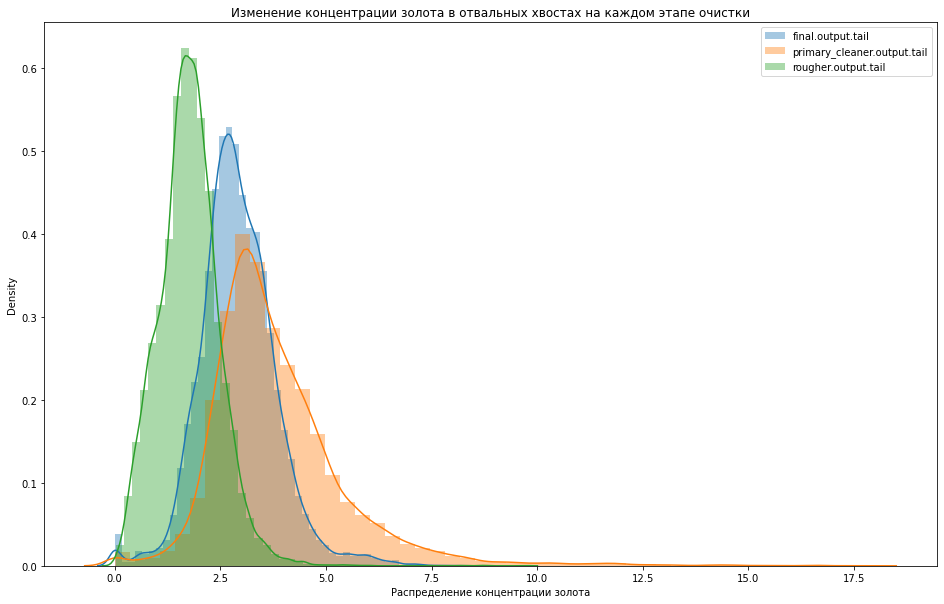

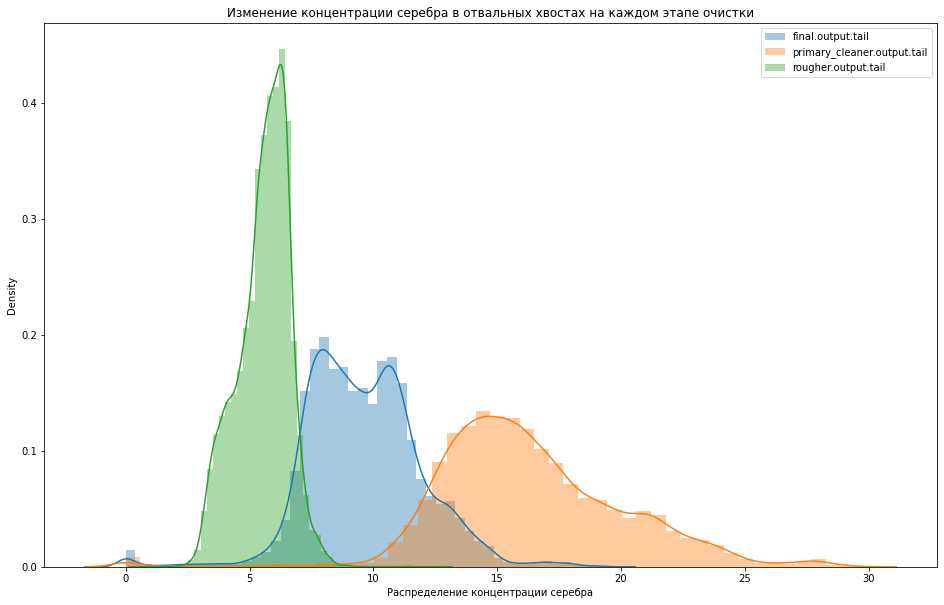

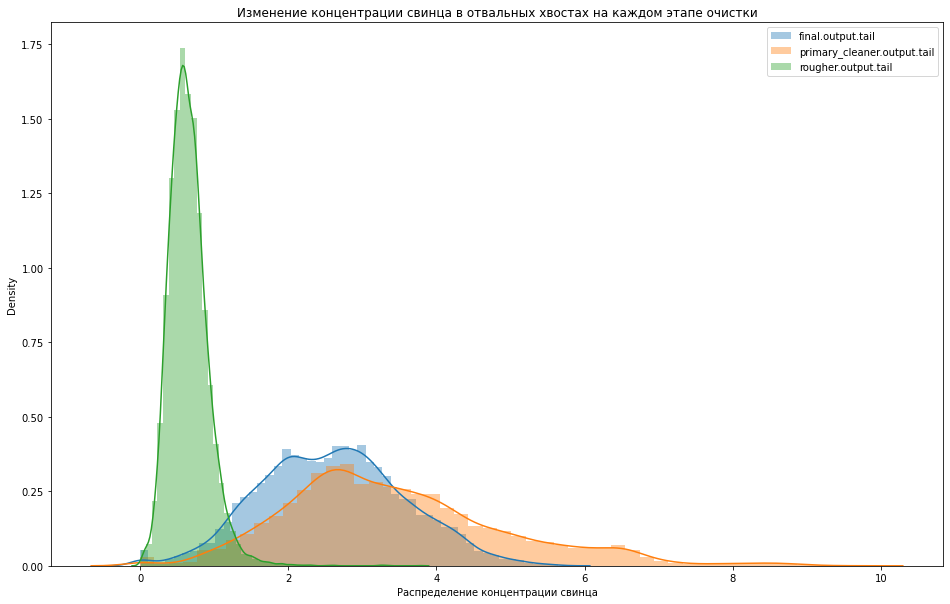

In [31]:
# строим графики распределения для содержания металлов в отвальных хвостах

METALS = [("au", "золота"), ("ag", "серебра"), ("pb", "свинца")]

for METAL in METALS:
    plt.figure(figsize=(16, 10))
    for STAGE in TAIL_F:
        ax = sns.distplot(TRAIN[STAGE + METAL[0]], label=STAGE[:-1])
        plt.legend()
        _ = ax.set(
            xlabel="Распределение концeнтрации " + METAL[1],
            title="Изменение концентрации "
            + METAL[1]
            + " в отвальных хвостах на каждом этапе очистки",
        )
    plt.show()

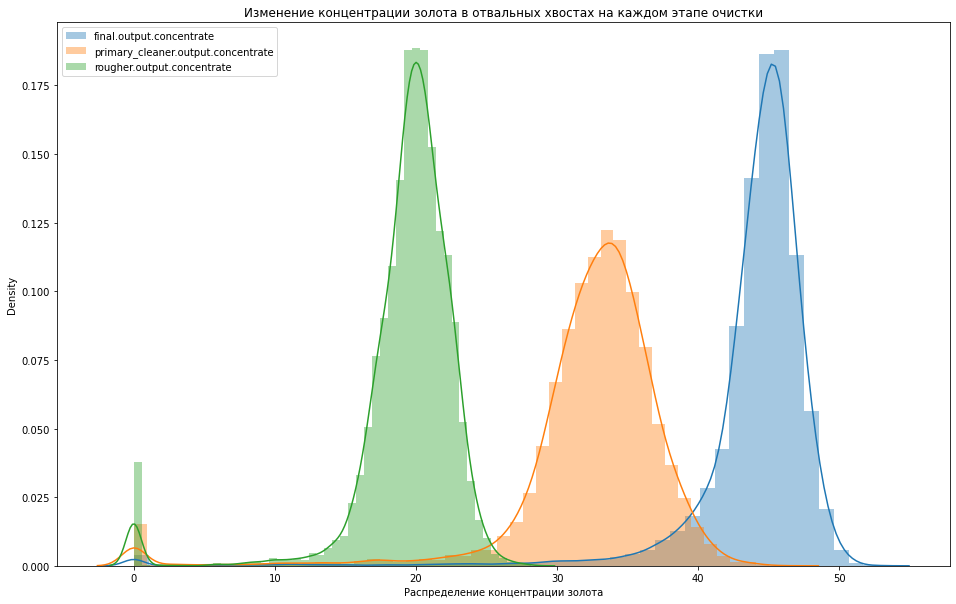

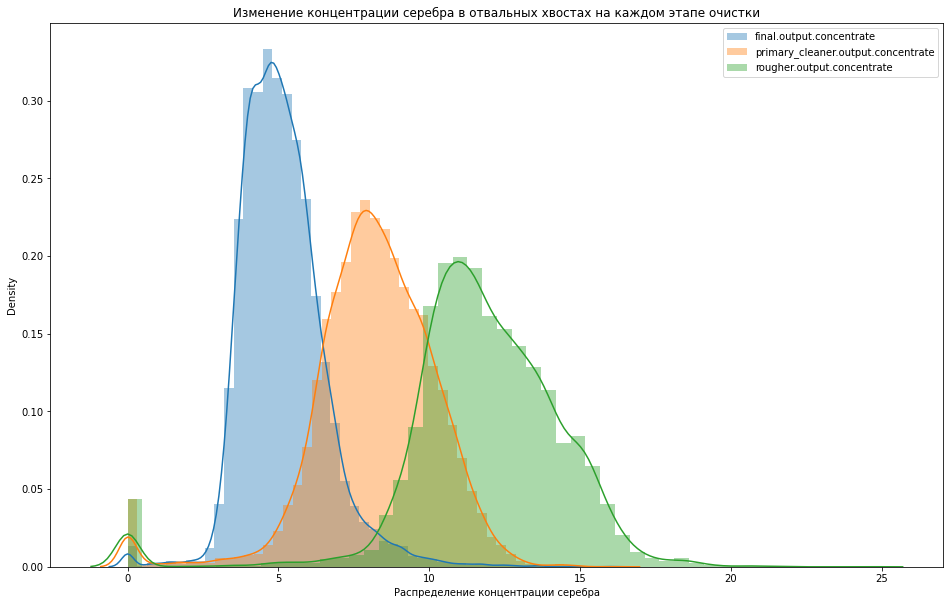

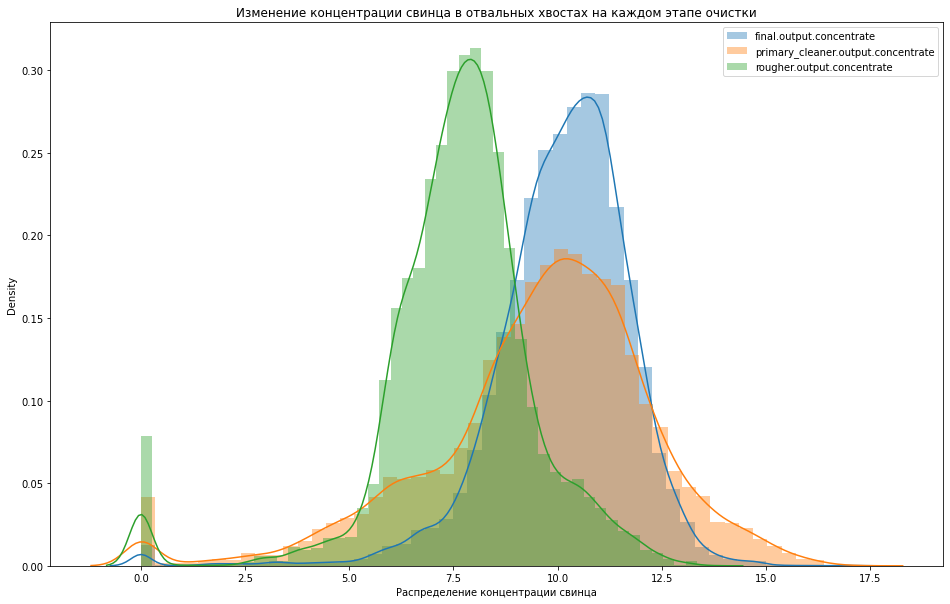

In [32]:
# строим графики распределения для содержания металлов в концентрате

METALS = [("au", "золота"), ("ag", "серебра"), ("pb", "свинца")]

for METAL in METALS:
    plt.figure(figsize=(16, 10))
    for STAGE in CONCENTRATE_F:
        ax = sns.distplot(TRAIN[STAGE + METAL[0]], label=STAGE[:-1])
        plt.legend()
        _ = ax.set(
            xlabel="Распределение концeнтрации " + METAL[1],
            title="Изменение концентрации "
            + METAL[1]
            + " в отвальных хвостах на каждом этапе очистки",
        )
    plt.show()

In [33]:
# удалим из обучающей выборки аномальные значения

TRAIN_SIZE_BEFORE = len(TRAIN)

TRAIN = TRAIN[
    ~TRAIN.index.isin(TRAIN[TRAIN["primary_cleaner.output.concentrate_au"] < 1].index)
]

TRAIN_SIZE_AFTER = len(TRAIN)

In [34]:
print(
    f"Из обучающей выборки удалено {TRAIN_SIZE_BEFORE - TRAIN_SIZE_AFTER} наблюдений, что составляет около  {1 - (TRAIN_SIZE_AFTER / TRAIN_SIZE_BEFORE):.2%} от ее общего размера"
)

Из обучающей выборки удалено 199 наблюдений, что составляет около  1.41% от ее общего размера


**Промежуточные выводы:**

На графиках, описывающих концентрацию металлов в отвальных хвостах видим следующее:

* Для золота все три распределения накладываются друг на друга и имеют "острую" форму - это говорит о том, что технологический процесс всецело выстроен вокруг необходимости извлечь максимально возможное количество металла из сырья, поэтому концентрация в отходах невысока
* Также для золота мы видим длинный "хвост" в правой части распределения - это говорит о том, что после обогащения руды в процессе флотации концентрация золота может быть относительно высока, что устраняется после второго этапа очистки
* Для серебра вышеперечисленные утверждения также справедливы, но так как этот продукт не является целевым, то и контроль (вероятно) не такой строгий, что видно по виду распределений. Концентрация металла также падает на финальном этапе - вероятно, производство старается извлечь максимум серебра (вероятно, это экономически целесообразно)
* У свинца наблюдается рост концентрации, но распределения значений для первого и второго этапов очистки довольно сильно "расплываются" по оси Х - видимо, минимизация концентрации не является первоочередной задачей для этого металла

На графиках, описывающих концентрацию металлов в отвальных хвостах видим следующее:

* Концентрация золота ожидаемо растет с каждым этапом. Распределения "острые" - видимо контроль за размахом значений ведется достаточно строгий
* Похожая ситуация и с серебром, но в случае этого металла распределения расположены кучнее - очевидно, этот металл не является целевым продуктом производства
* Концентрация свинца же растет после флотации, но сопоставими на двух последующих этапах очистки с той лишь разницей, что мода распределения на финальном этапе выше, а хвосты меньше
* На всех трех графиках присутствуют аномальных околонулевые значения для всех этапов (с перевесом в сторону флотации и второго этапа очистки)

### Распределения размеров гранул сырья на обучающей и тестовой выборках

Размер гранул сырья описывается признаком, содержащим значение `feed_size`.

In [35]:
# проверим признаки, в которых содержится искомое значение

for x in TEST.columns:
    if "feed_size" in x:
        print(x)

primary_cleaner.input.feed_size
rougher.input.feed_size


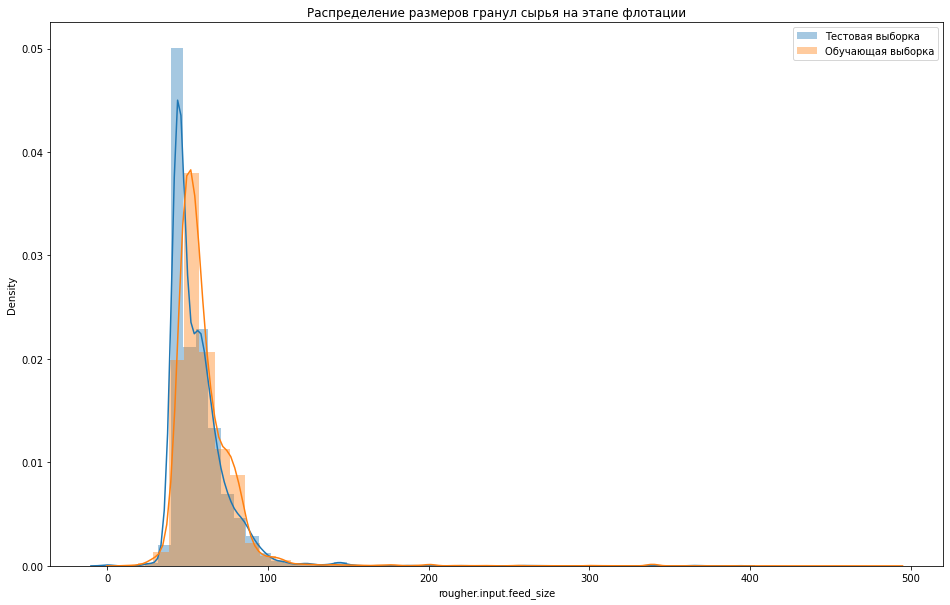

In [36]:
plt.figure(figsize=(16, 10))
sns.distplot(TEST["rougher.input.feed_size"], label="Тестовая выборка")
sns.distplot(TRAIN["rougher.input.feed_size"], label="Обучающая выборка")
plt.title("Распределение размеров гранул сырья на этапе флотации")
plt.legend()
plt.show()

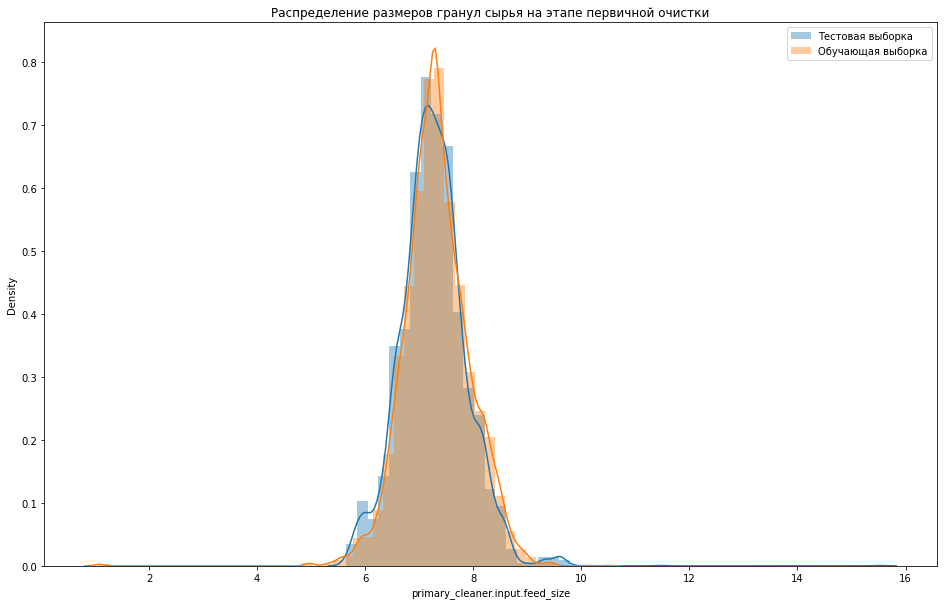

In [37]:
plt.figure(figsize=(16, 10))
sns.distplot(TEST["primary_cleaner.input.feed_size"], label="Тестовая выборка")
sns.distplot(TRAIN["primary_cleaner.input.feed_size"], label="Обучающая выборка")
plt.title("Распределение размеров гранул сырья на этапе первичной очистки")
plt.legend()
plt.show()

Мы видим, что для распределения обоих признаков накладываются друг на другу и находятся примерно в одинаковых диапазонах - следовательно, проблем с распределениями значений этого признака в выборках нет. 

###  Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [38]:
# соберем датафреймы для анализа суммарной концентрации

# этап 1 - концентрация веществ во входном сырье

ROUGHER_INPUT = (
    TRAIN["rougher.input.feed_ag"]
    + TRAIN["rougher.input.feed_pb"]
    + TRAIN["rougher.input.feed_sol"]
    + TRAIN["rougher.input.feed_au"]
)

# этап 2 - концентрация в черновом концентрате

ROUGHER_OUTPUT_CONCENTRATE = (
    TRAIN["rougher.output.concentrate_ag"]
    + TRAIN["rougher.output.concentrate_pb"]
    + TRAIN["rougher.output.concentrate_sol"]
    + TRAIN["rougher.output.concentrate_au"]
)

# этап 3 - концентрация в финальном концентрате

FINAL_CONCENTRATE = (
    TRAIN["final.output.concentrate_ag"]
    + TRAIN["final.output.concentrate_pb"]
    + TRAIN["final.output.concentrate_sol"]
    + TRAIN["final.output.concentrate_au"]
)

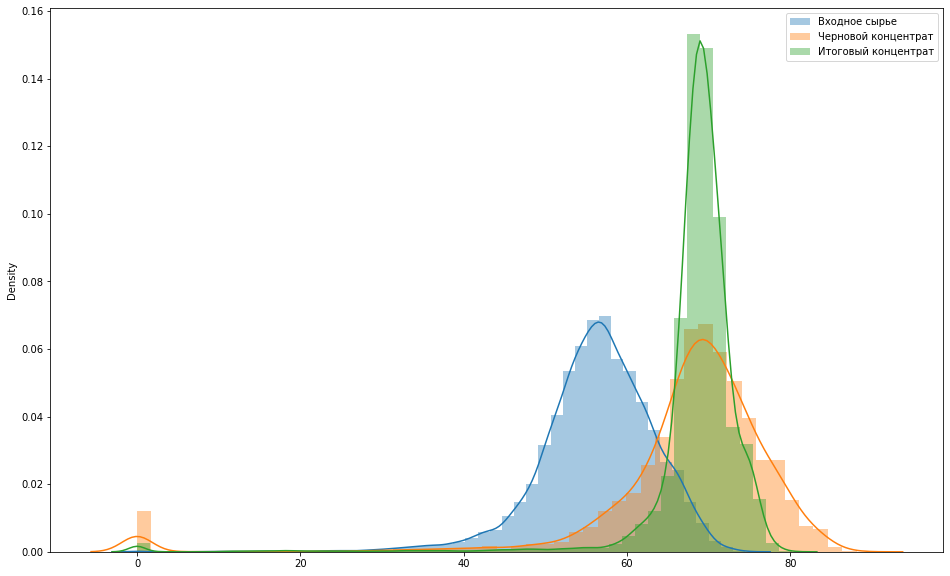

In [39]:
# на одном пространестве построим графики распределения для трех сформированных ранее векторов с концентрациями исходных веществ

plt.figure(figsize=(16, 10))
ax = sns.distplot(ROUGHER_INPUT, label="Входное сырье")
ax = sns.distplot(ROUGHER_OUTPUT_CONCENTRATE, label="Черновой концентрат")
ax = sns.distplot(FINAL_CONCENTRATE, label="Итоговый концентрат")
plt.legend()
plt.show()

In [40]:
# отбросим из тренировочной выборки все нулевые значения

for SERIES in [ROUGHER_INPUT, ROUGHER_OUTPUT_CONCENTRATE, FINAL_CONCENTRATE]:
    SERIES = SERIES.loc[SERIES < 1].index
    TRAIN = TRAIN[~TRAIN.index.isin(SERIES)]

TRAIN_SIZE_AFTER = len(TRAIN)

In [41]:
print(
    f"Из обучающей выборки удалено {TRAIN_SIZE_BEFORE - TRAIN_SIZE_AFTER} наблюдений, что составляет около  {1 - (TRAIN_SIZE_AFTER / TRAIN_SIZE_BEFORE):.2%} от ее общего размера"
)

Из обучающей выборки удалено 554 наблюдений, что составляет около  3.92% от ее общего размера


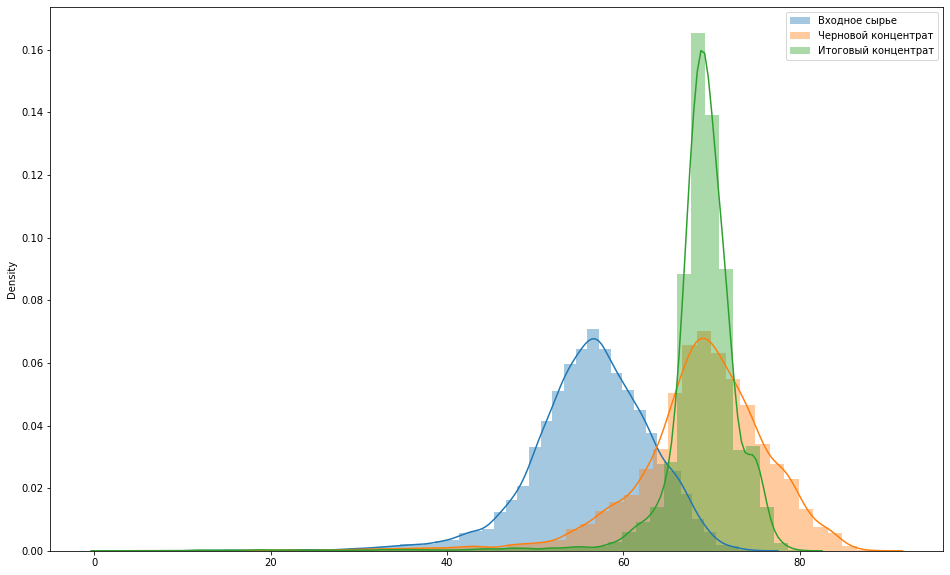

In [42]:
# повторно соберем датафреймы для анализа суммарной концентрации

# этап 1 - концентрация веществ во входном сырье

ROUGHER_INPUT = (
    TRAIN["rougher.input.feed_ag"]
    + TRAIN["rougher.input.feed_pb"]
    + TRAIN["rougher.input.feed_sol"]
    + TRAIN["rougher.input.feed_au"]
)

# этап 2 - концентрация в черновом концентрате

ROUGHER_OUTPUT_CONCENTRATE = (
    TRAIN["rougher.output.concentrate_ag"]
    + TRAIN["rougher.output.concentrate_pb"]
    + TRAIN["rougher.output.concentrate_sol"]
    + TRAIN["rougher.output.concentrate_au"]
)

# этап 3 - концентрация в финальном концентрате

FINAL_CONCENTRATE = (
    TRAIN["final.output.concentrate_ag"]
    + TRAIN["final.output.concentrate_pb"]
    + TRAIN["final.output.concentrate_sol"]
    + TRAIN["final.output.concentrate_au"]
)

plt.figure(figsize=(16, 10))
ax = sns.distplot(ROUGHER_INPUT, label="Входное сырье")
ax = sns.distplot(ROUGHER_OUTPUT_CONCENTRATE, label="Черновой концентрат")
ax = sns.distplot(FINAL_CONCENTRATE, label="Итоговый концентрат")
plt.legend()
plt.show()

**Промежуточные выводы:** 

1. Мы наблюдаем естественный рост концентрации веществ на выходе из флотации
2. Размах значений итогового концентрата лежит в пределах размаха черного концентрата, но форма распределения говорит нам о более стабильной концентрации веществ в выходном продукте
3. Из обучающей выборки удалены ничтожно малые значения общей концентрации - вероятно они являются ошибочными и не принесут пользы на последующих этапах

Так как на этапе исследования признаков обучающая выборка подверглась уменьшению, необходимо повторно воспроизвести процесс ее препроцессинга:

In [43]:
PREPROCESSED_TRAIN = TRAIN.loc[:, USEFUL_FEATURES]
PREPROCESSED_TRAIN = PREPROCESSED_TRAIN.fillna(method="ffill")

# Построение модели

## Функция SMAPE

In [44]:
# в соответствии с полученным описанием, подготовим функци для расчета метрики SMAPE


def smape(target, predictions):
    return (
        1
        / len(target)
        * sum(abs(target - predictions) / ((abs(target) + abs(predictions)) * 0.5))
        * 100
    )


def final_smape(smape_rougher, smape_output):
    return 0.25 * smape_rougher + 0.75 * smape_output

## Подготовка данных

Дополним ранее предобработанный датасет для обучения целевыми признаками из датасета с полными данными. 

In [45]:
PREPROCESSED_TRAIN = PREPROCESSED_TRAIN.merge(
    FULL[["date", "rougher.output.recovery", "final.output.recovery"]],
    on="date",
    how="left",
)

In [46]:
# разделим обучающую выборку на независимые переменный и целевые признаки

TRAIN_FEATURES = PREPROCESSED_TRAIN.drop(
    ["rougher.output.recovery", "final.output.recovery", "date"], axis=1
)

TRAIN_TARGET_DUAL = PREPROCESSED_TRAIN[
    ["rougher.output.recovery", "final.output.recovery"]
]
TRAIN_TARGET_ROUGHER_RECOVERY = PREPROCESSED_TRAIN["rougher.output.recovery"]
TRAIN_TARGET_OUTPUT_RECOVERY = PREPROCESSED_TRAIN["final.output.recovery"]

In [47]:
# разделим тестовую выборку

TEST = TEST.merge(
    FULL[["date", "rougher.output.recovery", "final.output.recovery"]],
    on="date",
    how="left",
)

# уберем пропуски в тестовой выборке

TEST = TEST.fillna(method="ffill")

TEST_FEATURES = TEST.drop(
    ["rougher.output.recovery", "final.output.recovery", "date"], axis=1
)

TEST_TARGET_DUAL = TEST[["rougher.output.recovery", "final.output.recovery"]]
TEST_TARGET_ROUGHER_RECOVERY = TEST["rougher.output.recovery"]
TEST_TARGET_OUTPUT_RECOVERY = TEST["final.output.recovery"]

In [48]:
# сделаем скейлинг для прогнозирования при помощи линейной регрессии

scaler = StandardScaler()

# выполним обучение скейлера и преобразование количественных переменных на выборках
TRAIN_FEATURES = scaler.fit_transform(TRAIN_FEATURES)
TEST_FEATURES = scaler.transform(TEST_FEATURES)

## Выбор наилучшей модели

### Линейная регрессия

In [49]:
# в две разные переменные положим по модели линейной регрессии

MODEL_ROUGHER_LINEAR = LinearRegression()
MODEL_OUTPUT_LINEAR = LinearRegression()

In [50]:
# кажду из моделей обучаем на подготовленном сете с фичами, но на разном векторе целевых признаков

MODEL_ROUGHER_LINEAR = MODEL_ROUGHER_LINEAR.fit(
    TRAIN_FEATURES, TRAIN_TARGET_ROUGHER_RECOVERY
)
MODEL_OUTPUT_LINEAR = MODEL_OUTPUT_LINEAR.fit(
    TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY
)

In [51]:
# строим предсказания с использованием каждой из обученных моделей

PREDICTIONS_ROUGHER = MODEL_ROUGHER_LINEAR.predict(TEST_FEATURES)
PREDICTIONS_OUTPUT = MODEL_OUTPUT_LINEAR.predict(TEST_FEATURES)

In [52]:
# при помощи кросс-валидации считаем sMAPE для каждой модели

SMAPE_ROUGHER = cross_val_score(
    MODEL_ROUGHER_LINEAR,
    TRAIN_FEATURES,
    TRAIN_TARGET_ROUGHER_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

SMAPE_OUTPUT = cross_val_score(
    MODEL_OUTPUT_LINEAR,
    TRAIN_FEATURES,
    TRAIN_TARGET_OUTPUT_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

In [53]:
print(
    f"sMAPE модели для предсказания эффективности обогащения чернового концентрата {SMAPE_ROUGHER:.2f}%"
)
print(
    f"sMAPE модели для предсказания эффективности обогащения финального концентрата {SMAPE_OUTPUT:.2f}%"
)
print(f"Общая sMAPE {final_smape(SMAPE_ROUGHER, SMAPE_OUTPUT):.2f}%")

sMAPE модели для предсказания эффективности обогащения чернового концентрата 7.31%
sMAPE модели для предсказания эффективности обогащения финального концентрата 11.05%
Общая sMAPE 10.12%


### Дерево решений

In [54]:
# так как начиная с модели дерева решений планируется использовать GridSearchCV для подбора наилучших гиперпараметров, соберем скорер на базе целевой метрики

smape_score = make_scorer(smape, greater_is_better=False)

In [55]:
# в две разные переменные положим по модели

MODEL_ROUGHER_TREE = DecisionTreeRegressor(random_state=12345)
MODEL_OUTPUT_TREE = DecisionTreeRegressor(random_state=12345)

In [56]:
# обучаем деревья на дефолтных гиперпараметрах

MODEL_ROUGHER_TREE = MODEL_ROUGHER_TREE.fit(
    TRAIN_FEATURES, TRAIN_TARGET_ROUGHER_RECOVERY
)
MODEL_OUTPUT_TREE = MODEL_OUTPUT_TREE.fit(TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY)

In [57]:
# строим предсказания с использованием каждой из обученных моделей

PREDICTIONS_ROUGHER = MODEL_ROUGHER_TREE.predict(TEST_FEATURES)
PREDICTIONS_OUTPUT = MODEL_OUTPUT_TREE.predict(TEST_FEATURES)

In [58]:
# при помощи кросс-валидации считаем sMAPE для каждой модели

SMAPE_ROUGHER = cross_val_score(
    MODEL_ROUGHER_TREE,
    TRAIN_FEATURES,
    TRAIN_TARGET_ROUGHER_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

SMAPE_OUTPUT = cross_val_score(
    MODEL_OUTPUT_TREE,
    TRAIN_FEATURES,
    TRAIN_TARGET_OUTPUT_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

In [59]:
print(
    f"sMAPE модели для предсказания эффективности обогащения чернового концентрата {SMAPE_ROUGHER:.2f}%"
)
print(
    f"sMAPE модели для предсказания эффективности обогащения финального концентрата {SMAPE_OUTPUT:.2f}%"
)
print(f"Общая sMAPE {final_smape(SMAPE_ROUGHER, SMAPE_OUTPUT):.2f}%")

sMAPE модели для предсказания эффективности обогащения чернового концентрата 9.15%
sMAPE модели для предсказания эффективности обогащения финального концентрата 17.19%
Общая sMAPE 15.18%


Наблюдаем худшие значения целевой метрики для модели с дефолтными параметрами.

Перейдем к подбору гиперпараметров для дерева. Для дерева решений используем следующие: 

* Минимальное количество семплом для разбивки уровня
* Максимальная глубина дерева

In [60]:
# соберем сетку параметров с возможными диапазонами, в рамках которых и будет произведен перебор

PARAM_GRID = {
    "min_samples_split": [x for x in range(50, 251, 50)],
    "max_depth": [x for x in range(10, 110, 10)],
}

In [61]:
# создаем переменную в которую кладем объект GridSearchCV с заданными параметрами и ссылкой на сетку параметров

GRID_CV = GridSearchCV(
    MODEL_ROUGHER_TREE, PARAM_GRID, cv=5, return_train_score=False, scoring=smape_score
)

In [62]:
GRID_CV.fit(TRAIN_FEATURES, TRAIN_TARGET_ROUGHER_RECOVERY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'min_samples_split': [50, 100, 150, 200, 250]},
             scoring=make_scorer(smape, greater_is_better=False))

In [63]:
REPORT = pd.DataFrame(GRID_CV.cv_results_)
REPORT = REPORT[
    ["param_max_depth", "param_min_samples_split", "mean_test_score", "rank_test_score"]
]
REPORT = REPORT.sort_values(by="rank_test_score")
REPORT.head(20)

,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
2,10,150,-7.070916,1
9,20,250,-7.079313,2
24,50,250,-7.079442,3
44,90,250,-7.079442,3
39,80,250,-7.079442,3
34,70,250,-7.079442,3
29,60,250,-7.079442,3
19,40,250,-7.079442,3
14,30,250,-7.079442,3
49,100,250,-7.079442,3


In [64]:
# объявляем модель для предсказания эффективности обогащения чернового концентрата с наилучшими параметрами

MODEL_ROUGHER_TREE = DecisionTreeRegressor(
    random_state=12345, min_samples_split=150, max_depth=10
)

In [65]:
GRID_CV = GridSearchCV(
    MODEL_OUTPUT_TREE, PARAM_GRID, cv=5, return_train_score=False, scoring=smape_score
)

In [66]:
GRID_CV.fit(TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'min_samples_split': [50, 100, 150, 200, 250]},
             scoring=make_scorer(smape, greater_is_better=False))

In [67]:
REPORT = pd.DataFrame(GRID_CV.cv_results_)
REPORT = REPORT[
    ["param_max_depth", "param_min_samples_split", "mean_test_score", "rank_test_score"]
]
REPORT = REPORT.sort_values(by="rank_test_score")
REPORT.head(20)

,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
3,10,200,-11.762108,1
4,10,250,-12.016573,2
1,10,100,-12.091648,3
9,20,250,-12.177815,4
14,30,250,-12.248736,5
24,50,250,-12.248979,6
44,90,250,-12.248979,6
39,80,250,-12.248979,6
34,70,250,-12.248979,6
29,60,250,-12.248979,6


In [68]:
# попробуем немного отрегулировать сетку параметров и добавим еще один параметр

PARAM_GRID = {
    "min_samples_split": [x for x in range(100, 1100, 100)],
    "max_depth": [10, 20, 30],
    "max_leaf_nodes": [5, 10, 20, 40, 80],
}

GRID_CV = GridSearchCV(
    MODEL_OUTPUT_TREE, PARAM_GRID, cv=5, return_train_score=False, scoring=smape_score
)

In [69]:
GRID_CV.fit(TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [10, 20, 30],
                         'max_leaf_nodes': [5, 10, 20, 40, 80],
                         'min_samples_split': [100, 200, 300, 400, 500, 600,
                                               700, 800, 900, 1000]},
             scoring=make_scorer(smape, greater_is_better=False))

In [70]:
REPORT = pd.DataFrame(GRID_CV.cv_results_)
REPORT = REPORT[
    [
        "param_max_depth",
        "param_min_samples_split",
        "param_max_leaf_nodes",
        "mean_test_score",
        "rank_test_score",
    ]
]
REPORT = REPORT.sort_values(by="rank_test_score")
REPORT.head(20)

,param_max_depth,param_min_samples_split,param_max_leaf_nodes,mean_test_score,rank_test_score
0,10,100,5,-9.33839,1
107,30,800,5,-9.33839,1
106,30,700,5,-9.33839,1
105,30,600,5,-9.33839,1
56,20,700,5,-9.33839,1
104,30,500,5,-9.33839,1
103,30,400,5,-9.33839,1
102,30,300,5,-9.33839,1
101,30,200,5,-9.33839,1
100,30,100,5,-9.33839,1


In [71]:
# объявляем модель для предсказания эффективности обогащения итогового концентрата с наилучшими параметрами

MODEL_OUTPUT_TREE = DecisionTreeRegressor(
    random_state=12345, min_samples_split=100, max_depth=10, max_leaf_nodes=5
)

In [72]:
# при помощи кросс-валидации считаем sMAPE для каждой модели

SMAPE_ROUGHER = cross_val_score(
    MODEL_ROUGHER_TREE,
    TRAIN_FEATURES,
    TRAIN_TARGET_ROUGHER_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

SMAPE_OUTPUT = cross_val_score(
    MODEL_OUTPUT_TREE,
    TRAIN_FEATURES,
    TRAIN_TARGET_OUTPUT_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

In [73]:
print(
    f"sMAPE модели для предсказания эффективности обогащения чернового концентрата {SMAPE_ROUGHER:.2f}%"
)
print(
    f"sMAPE модели для предсказания эффективности обогащения финального концентрата {SMAPE_OUTPUT:.2f}%"
)
print(f"Общая sMAPE {final_smape(SMAPE_ROUGHER, SMAPE_OUTPUT):.2f}%")

sMAPE модели для предсказания эффективности обогащения чернового концентрата 7.07%
sMAPE модели для предсказания эффективности обогащения финального концентрата 9.34%
Общая sMAPE 8.77%


### Случайный лес

In [74]:
# в две разные переменные положим по модели

MODEL_ROUGHER_FOREST = RandomForestRegressor(random_state=12345)
MODEL_OUTPUT_FOREST = RandomForestRegressor(random_state=12345)

In [75]:
# обучаем деревья на дефолтных гиперпараметрах

MODEL_ROUGHER_FOREST = MODEL_ROUGHER_FOREST.fit(
    TRAIN_FEATURES, TRAIN_TARGET_ROUGHER_RECOVERY
)
MODEL_OUTPUT_FOREST = MODEL_OUTPUT_FOREST.fit(
    TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY
)

In [76]:
# при помощи кросс-валидации считаем sMAPE для каждой модели

SMAPE_ROUGHER = cross_val_score(
    MODEL_ROUGHER_FOREST,
    TRAIN_FEATURES,
    TRAIN_TARGET_ROUGHER_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

SMAPE_OUTPUT = cross_val_score(
    MODEL_OUTPUT_FOREST,
    TRAIN_FEATURES,
    TRAIN_TARGET_OUTPUT_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

In [77]:
print(
    f"sMAPE модели для предсказания эффективности обогащения чернового концентрата {SMAPE_ROUGHER:.2f}%"
)
print(
    f"sMAPE модели для предсказания эффективности обогащения финального концентрата {SMAPE_OUTPUT:.2f}%"
)
print(f"Общая sMAPE {final_smape(SMAPE_ROUGHER, SMAPE_OUTPUT):.2f}%")

sMAPE модели для предсказания эффективности обогащения чернового концентрата 6.45%
sMAPE модели для предсказания эффективности обогащения финального концентрата 9.58%
Общая sMAPE 8.80%


In [78]:
# попробуем немного отрегулировать сетку параметров и добавим еще один параметр

PARAM_GRID = {
    "n_estimators": [x for x in range(2, 11)],
    "min_samples_split": [x for x in range(50, 251, 50)],
    "max_depth": [5, 10, 20],
    "max_leaf_nodes": [10, 20],
}

GRID_CV = GridSearchCV(
    MODEL_ROUGHER_FOREST,
    PARAM_GRID,
    cv=5,
    return_train_score=False,
    scoring=smape_score,
)

In [79]:
%%time

GRID_CV.fit(TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY)

CPU times: user 21min 24s, sys: 633 ms, total: 21min 24s
Wall time: 21min 25s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5, 10, 20], 'max_leaf_nodes': [10, 20],
                         'min_samples_split': [50, 100, 150, 200, 250],
                         'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring=make_scorer(smape, greater_is_better=False))

In [80]:
REPORT = pd.DataFrame(GRID_CV.cv_results_)
REPORT = REPORT[
    [
        "param_max_depth",
        "param_min_samples_split",
        "param_max_leaf_nodes",
        "param_n_estimators",
        "mean_test_score",
        "rank_test_score",
    ]
]
REPORT = REPORT.sort_values(by="rank_test_score")
REPORT.head(20)

,param_max_depth,param_min_samples_split,param_max_leaf_nodes,param_n_estimators,mean_test_score,rank_test_score
68,5,150,20,7,-9.121593,1
71,5,150,20,10,-9.133146,2
86,5,250,20,7,-9.136119,3
89,5,250,20,10,-9.146694,4
77,5,200,20,7,-9.148731,5
143,10,50,20,10,-9.150172,6
233,20,50,20,10,-9.150172,6
59,5,100,20,7,-9.150797,8
80,5,200,20,10,-9.162220,9
50,5,50,20,7,-9.178162,10


In [81]:
MODEL_ROUGHER_FOREST = RandomForestRegressor(
    random_state=12345,
    max_depth=5,
    min_samples_split=150,
    max_leaf_nodes=20,
    n_estimators=7,
)

In [82]:
# попробуем немного отрегулировать сетку параметров и добавим еще один параметр

PARAM_GRID = {
    "n_estimators": [5, 10, 20, 30],
    "min_samples_split": [100, 200],
    "max_depth": [5, 10, 20],
    "max_leaf_nodes": [10, 20],
}

GRID_CV = GridSearchCV(
    MODEL_OUTPUT_FOREST,
    PARAM_GRID,
    cv=5,
    return_train_score=False,
    scoring=smape_score,
)

In [83]:
%%time

GRID_CV.fit(TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY)

CPU times: user 10min 14s, sys: 395 ms, total: 10min 14s
Wall time: 10min 14s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5, 10, 20], 'max_leaf_nodes': [10, 20],
                         'min_samples_split': [100, 200],
                         'n_estimators': [5, 10, 20, 30]},
             scoring=make_scorer(smape, greater_is_better=False))

In [84]:
REPORT = pd.DataFrame(GRID_CV.cv_results_)
REPORT = REPORT[
    [
        "param_max_depth",
        "param_min_samples_split",
        "param_max_leaf_nodes",
        "param_n_estimators",
        "mean_test_score",
        "rank_test_score",
        "mean_fit_time",
    ]
]
REPORT = REPORT.sort_values(by="rank_test_score")
REPORT.head(20)

,param_max_depth,param_min_samples_split,param_max_leaf_nodes,param_n_estimators,mean_test_score,rank_test_score,mean_fit_time
14,5,200,20,20,-8.933713,1,3.050213
15,5,200,20,30,-8.950135,2,4.547927
10,5,100,20,20,-8.953374,3,3.029212
30,10,200,20,20,-8.964819,4,3.668537
46,20,200,20,20,-8.964819,4,3.683753
47,20,200,20,30,-8.993900,6,5.486878
31,10,200,20,30,-8.993900,6,5.631448
11,5,100,20,30,-9.019573,8,4.517001
42,20,100,20,20,-9.027445,9,3.569675
26,10,100,20,20,-9.027445,9,3.571019


In [85]:
MODEL_OUTPUT_FOREST = RandomForestRegressor(
    random_state=12345,
    max_depth=5,
    min_samples_split=200,
    max_leaf_nodes=20,
    n_estimators=20,
)

In [86]:
# при помощи кросс-валидации считаем sMAPE для каждой модели

SMAPE_ROUGHER = cross_val_score(
    MODEL_ROUGHER_FOREST,
    TRAIN_FEATURES,
    TRAIN_TARGET_ROUGHER_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

SMAPE_OUTPUT = cross_val_score(
    MODEL_OUTPUT_FOREST,
    TRAIN_FEATURES,
    TRAIN_TARGET_OUTPUT_RECOVERY,
    scoring=make_scorer(smape),
    cv=5,
    n_jobs=-1,
).mean()

In [87]:
print(
    f"sMAPE модели для предсказания эффективности обогащения чернового концентрата {SMAPE_ROUGHER:.2f}%"
)
print(
    f"sMAPE модели для предсказания эффективности обогащения финального концентрата {SMAPE_OUTPUT:.2f}%"
)
print(f"Общая sMAPE {final_smape(SMAPE_ROUGHER, SMAPE_OUTPUT):.2f}%")

sMAPE модели для предсказания эффективности обогащения чернового концентрата 6.33%
sMAPE модели для предсказания эффективности обогащения финального концентрата 8.93%
Общая sMAPE 8.28%


* Наилучший результат был достигнут при помощи случайного леса
* Для прогнозирования эффективности обогащения чернового концентрата используются следующие гиперпараметры:
    * max_depth=5 
    * min_samples_split=150 
    * max_leaf_nodes=20 
    * n_estimators=7
* Для прогнозирования эффективности обогащения итогового концентрата используются следующие гиперпараметры:
    * max_depth=5
    * min_samples_split=200
    * max_leaf_nodes=20
    * n_estimators=20

## Проверка модели на тестовой выборке

In [88]:
FINAL_MODEL_ROUGHER = RandomForestRegressor(
    random_state=12345,
    max_depth=5,
    min_samples_split=150,
    max_leaf_nodes=20,
    n_estimators=7,
)

FINAL_MODEL_OUTPUT = RandomForestRegressor(
    random_state=12345,
    max_depth=5,
    min_samples_split=200,
    max_leaf_nodes=20,
    n_estimators=20,
)

In [89]:
FINAL_MODEL_ROUGHER = FINAL_MODEL_ROUGHER.fit(
    TRAIN_FEATURES, TRAIN_TARGET_ROUGHER_RECOVERY
)

FINAL_MODEL_OUTPUT = FINAL_MODEL_OUTPUT.fit(
    TRAIN_FEATURES, TRAIN_TARGET_OUTPUT_RECOVERY
)

In [90]:
rougher_predictions = FINAL_MODEL_ROUGHER.predict(TEST_FEATURES)

output_predictions = FINAL_MODEL_OUTPUT.predict(TEST_FEATURES)

In [91]:
SMAPE_ROUGHER = smape(TEST_TARGET_ROUGHER_RECOVERY, rougher_predictions)

SMAPE_OUTPUT = smape(TEST_TARGET_OUTPUT_RECOVERY, output_predictions)

In [92]:
print(
    f"sMAPE модели для предсказания эффективности обогащения чернового концентрата {SMAPE_ROUGHER:.2f}%"
)
print(
    f"sMAPE модели для предсказания эффективности обогащения финального концентрата {SMAPE_OUTPUT:.2f}%"
)
print(f"Общая sMAPE {final_smape(SMAPE_ROUGHER, SMAPE_OUTPUT):.2f}%")

sMAPE модели для предсказания эффективности обогащения чернового концентрата 8.21%
sMAPE модели для предсказания эффективности обогащения финального концентрата 9.83%
Общая sMAPE 9.42%


## Выводы

* В ходе проверки возможных моделей кросс-валидацией установлено, что наилучший результат получается с использование алгоритма случайного леса
* sMAPE случайного леса на обучающей выборке - 8.3%
* Выбранная модель на тестовой выборке дала следующий результат sMAPE - 9.4%